In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pymining import seqmining
from tqdm.notebook import tqdm
from itertools import permutations, count

In [19]:
def generate_candidate_subsequences(freq_sequences, alphabet, r):
    if r==1:
        N = len(alphabet)
        return dict( zip( alphabet, [0]*N ) )

    left_candidates = list(
        map(lambda seq: (seq[0], seq[1:]), freq_sequences)
    )
    right_candidates = list(
        map(lambda seq: (seq[-1], seq[:-1]), freq_sequences)
    )

    
    candidates = set()
    for l_first, l in left_candidates:
        for r_last, r in right_candidates:
            if l==r:
                candidates|={ l_first + l + r_last }
    
    N = len(candidates)
    return dict(zip( candidates, [0] * N))
    
    
def prune_candidates(freq_candidates, freq_subsequences):
    freq_sequences = freq_candidates.copy()
    
    for seq in freq_candidates:
        for i in range(len(seq)):
            if (seq[:i] + seq[i+1:]) not in freq_subsequences:
                freq_sequences.pop(seq)
                break

                
def GSP(database, alphabet = ["a", "c", "g", "t"], threshold=0.1):
    r=1
    N = len(database)
    all_sets = {}
    current_sets = generate_candidate_subsequences({}, alphabet, r)
    
    while len(current_sets)>0:        
        for subseq in current_sets:
            for seq in database:
                if subseq in seq:
                    current_sets[subseq]+=1/N
    
        current_sets = dict(
            filter(lambda seq_sup_pair: seq_sup_pair[1]>=threshold, current_sets.items())
        )
        
        all_sets|=current_sets
        current_sets = generate_candidate_subsequences(current_sets, alphabet, (r:=r+1))
        prune_candidates(current_sets, all_sets)
        
    return all_sets

In [2]:
database = pd.DataFrame(
    data = {
        "sequence":["tatgagcata", "ctaacagttg", "acgcttttta", 
                    "tagcgggaag", "tgacgctgca", "tcgtggatgg", 
                    "ctgagtgctt", "gctttcttgt", "gacagattca", "atccatctac"],
        "class": [1]*5 + [0]*5
    }
)

In [3]:
database

,sequence,class
0,tatgagcata,1
1,ctaacagttg,1
2,acgcttttta,1
3,tagcgggaag,1
4,tgacgctgca,1
5,tcgtggatgg,0
6,ctgagtgctt,0
7,gctttcttgt,0
8,gacagattca,0
9,atccatctac,0


In [15]:
db_pos = database[database["class"]==1]
db_neg = database[database["class"]==0]

In [22]:
0.8*5

4.0

In [24]:
db_pos

,sequence,class
0,tatgagcata,1
1,ctaacagttg,1
2,acgcttttta,1
3,tagcgggaag,1
4,tgacgctgca,1


In [23]:
seqmining.freq_seq_enum(db_pos.sequence, 4)

{(('a',), 5),
 (('a', 'a'), 5),
 (('a', 'c'), 5),
 (('a', 'c', 'a'), 5),
 (('a', 'c', 'g'), 4),
 (('a', 'c', 't'), 4),
 (('a', 'g'), 5),
 (('a', 'g', 'a'), 4),
 (('a', 'g', 'c'), 4),
 (('a', 'g', 'c', 'a'), 4),
 (('a', 'g', 'g'), 4),
 (('a', 'g', 't'), 4),
 (('a', 't'), 4),
 (('c',), 5),
 (('c', 'a'), 5),
 (('c', 'g'), 4),
 (('c', 't'), 4),
 (('c', 't', 'a'), 4),
 (('g',), 5),
 (('g', 'a'), 4),
 (('g', 'c'), 4),
 (('g', 'c', 'a'), 4),
 (('g', 'g'), 4),
 (('g', 't'), 4),
 (('t',), 5),
 (('t', 'a'), 5),
 (('t', 'a', 'a'), 4),
 (('t', 'a', 'c'), 4),
 (('t', 'a', 'c', 'a'), 4),
 (('t', 'a', 'g'), 4),
 (('t', 'a', 'g', 'g'), 4),
 (('t', 'c'), 4),
 (('t', 'c', 'a'), 4),
 (('t', 'g'), 4),
 (('t', 'g', 'g'), 4),
 (('t', 't'), 4)}

In [20]:
GSP(db_pos.sequence, threshold=0.8)

{'a': 1.0, 'c': 1.0, 'g': 1.0, 't': 1.0, 'ta': 0.8, 'gc': 0.8}

In [177]:
GSP(db_pos["sequence"], threshold=0.8)

{'a': 1.0, 'c': 1.0, 'g': 1.0, 't': 1.0, 'ta': 0.8, 'gc': 0.8}

In [178]:
GSP(db_neg["sequence"], threshold=0.8)

{'a': 0.8, 'c': 1.0, 'g': 0.8, 't': 1.0, 'tc': 0.8}

In [179]:
get_closed_freq_set(GSP(db_pos["sequence"], threshold=0.8))

  0%|          | 0/6 [00:00<?, ?it/s]

{'a': 1.0, 'c': 1.0, 'g': 1.0, 't': 1.0, 'ta': 0.8, 'gc': 0.8}

In [180]:
get_closed_freq_set(GSP(db_neg["sequence"], threshold=0.8))

  0%|          | 0/5 [00:00<?, ?it/s]

{'a': 0.8, 'c': 1.0, 'g': 0.8, 't': 1.0, 'tc': 0.8}

In [25]:
df = pd.read_csv("data/chimpanzee.txt", delimiter="\t")

In [26]:
df.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


In [27]:
df.loc[df["class"]!=6,"class"] = 0

In [28]:
df.loc[df["class"]==6,"class"] = 1

<Axes: xlabel='class', ylabel='count'>

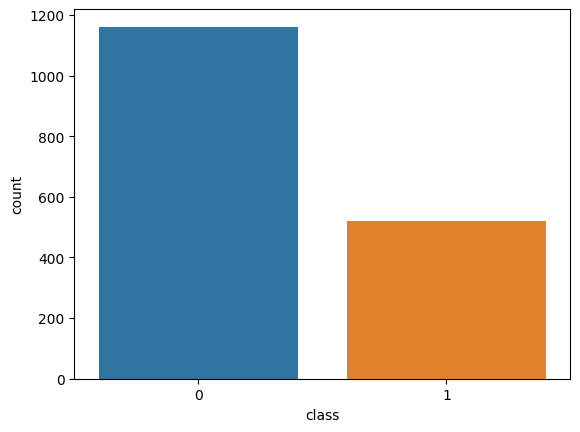

In [29]:
sns.countplot(df, x="class")

In [30]:
np.unique(df.sequence.apply(list).loc[0])

array(['A', 'C', 'G', 'T'], dtype='<U1')

In [31]:
df.sequence = df.sequence.apply(str.lower)

In [32]:
df.sequence

0       atgccccaactaaataccgccgtatgacccaccataattaccccca...
1       atgaacgaaaatctattcgcttcattcgctgcccccacaatcctag...
2       atggcctcgcgctggtggcggtggcgacgcggctgctcctggaggc...
3       atggcctcgcgctggtggcggtggcgacgcggctgctcctggaggc...
4       atgggcagcgccagcccgggtctgagcagcgtgtcccccagccacc...
                              ...                        
1677    atgctgagcggagcggctggggctgcgcggcgtggcggagcagcgc...
1678    atgctgagcggagcggctggggctgcgcggcgtggcggagcagcgc...
1679    atgaagcgacccaaggagccgagcggctccgacggggagtccgacg...
1680    atgactggaaccccaaagactcaagaaggagctaaagatcttgaag...
1681    atgttgcccagctgtggcaagatcttgactgggtgtaagaatatgc...
Name: sequence, Length: 1682, dtype: object

In [35]:
df[df["class"]==1]

(521, 2)

In [36]:
seqmining.freq_seq_enum(df[df["class"]==1].sequence, 500)


KeyboardInterrupt



In [138]:
freqs = [GSP(df[df["class"]==i].sequence, threshold=0.5) for i in tqdm(df["class"].unique())]

  0%|          | 0/2 [00:00<?, ?it/s]

In [139]:
len(freqs[0])

1731

In [140]:
def get_closed_freq_set(freq_sets):
    closed_sets = {}
    for seq in tqdm(freq_sets):
        N = len(seq)
        super_sets = dict(filter(lambda x: x[0][:N] == seq, freq_sets.items()))
        super_sets.pop(seq)
        
        if len(super_sets)>0:
            is_closed=True
            for support in super_sets.values():
                if support == freq_sets[seq]:
                    is_closed=False
                    break
            
            if is_closed:
                closed_sets|={seq:freq_sets[seq]}
    return closed_sets

In [181]:
closed_freqs = [ get_closed_freq_set(freq_set) for freq_set in freqs ]

  0%|          | 0/1731 [00:00<?, ?it/s]

  0%|          | 0/1192 [00:00<?, ?it/s]

In [182]:
list(map(len, closed_freqs))

[1719, 1178]

In [183]:
list(map(len, freqs))

[1731, 1192]

In [144]:
def get_distinct_freq_set(freq_sets, i):
    seqs = set(freq_sets[i].keys())
    for idx, seq_set in enumerate(freq_sets):
        if idx!=i:
            seqs-=set(seq_set.keys())
    return seqs

In [145]:
distinct_sets = [ get_distinct_freq_set(freqs, i) for i in range(len( closed_freqs )) ]

In [146]:
distinct_sets[1]

{'aacaag',
 'acgac',
 'acgcc',
 'caacag',
 'cagcagc',
 'ccaccc',
 'ccccaa',
 'ccgac',
 'cctccc',
 'ctccaa',
 'ctcccc',
 'ctcgc',
 'gagccc',
 'taatg'}

In [70]:
a_counts = df.sequence.apply(lambda x: x.count("a"))
c_counts = df.sequence.apply(lambda x: x.count("c"))
g_counts = df.sequence.apply(lambda x: x.count("g"))
t_counts = df.sequence.apply(lambda x: x.count("t"))

In [129]:
for seq in distinct_sets[1]:
    N = len(seq)
    print(
        df[df["class"]==1].sequence.apply(lambda x: seq == x[:N]).sum(), "/", df[df["class"]==1].sequence.count(), "=",
        df[df["class"]==1].sequence.apply(lambda x: seq == x[:N]).sum()/df[df["class"]==1].sequence.count()
    )

0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0
0 / 521 = 0.0


In [130]:
for seq in distinct_sets[1]:
    N=len(seq)
    print(
        df[df["class"]==0].sequence.apply(lambda x: seq == x[:N]).sum(), "/", df[df["class"]==0].sequence.count(), "=",
        df[df["class"]==0].sequence.apply(lambda x: seq == x[:N]).sum()/df[df["class"]==0].sequence.count()
    )

0 / 1161 = 0.0
0 / 1161 = 0.0
0 / 1161 = 0.0
0 / 1161 = 0.0
0 / 1161 = 0.0
0 / 1161 = 0.0
0 / 1161 = 0.0
0 / 1161 = 0.0
0 / 1161 = 0.0
0 / 1161 = 0.0
0 / 1161 = 0.0
0 / 1161 = 0.0
1 / 1161 = 0.0008613264427217916
0 / 1161 = 0.0
